# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import time
from multiprocessing import Pool
import subprocess as sp

from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file, save_hdf5_file
from polychrom.contactmaps import monomerResolutionContactMapSubchains

from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['svg.fonttype'] = 'none'
%config InlineBackend.figure_format='retina'

# Define functions

In [2]:
def get_Ps_curve_sim(contact_map):  
    '''Get the P(s) curve of a simulated monomer-resolution contact map.'''
    dist_arr = np.arange(0, contact_map.shape[0])  # array of distances to calculate P(s) for (in monomers)
    mean_contact_prob_arr = np.zeros(len(dist_arr))
    for i, dist in enumerate(dist_arr):
        contact_probs_along_diag = np.diag(contact_map, dist)
        mean_contact_prob_arr[i] = np.mean(contact_probs_along_diag)  # ignore nan's
    return dist_arr, mean_contact_prob_arr

# Open files

In [3]:
files = list_URIs('/mnt/coldstorage/jjusuf/simabsloopquant_data/3D_polysim_data_final/3D_polysim_data_with_loopextr_with_EP_3kBT/')
print(f'+LE +EP: {len(files)} blocks')

+LE +EP: 1076000 blocks


In [4]:
files_no_EP = list_URIs('/mnt/coldstorage/jjusuf/simabsloopquant_data/3D_polysim_data_final/3D_polysim_data_with_loopextr_no_EP/')
print(f'+LE -EP: {len(files_no_EP)} blocks')

+LE -EP: 1082000 blocks


In [5]:
files_no_LE_no_EP = list_URIs('/mnt/coldstorage/jjusuf/simabsloopquant_data/3D_polysim_data_final/3D_polysim_data_no_loopextr_no_EP/')
print(f'-LE -EP: {len(files_no_LE_no_EP)} blocks')

-LE -EP: 1000000 blocks


# Calculate the 2000x2000 contact map

In [6]:
region_size = 2000
chrom_size = 70000
num_regions = chrom_size // region_size
region_starts = np.arange(num_regions) * region_size

block_start = 500000
block_end = 1000000
block_step = 100


In [7]:
cutoff = 3
nproc = 50

start_time = time.time()
cm = monomerResolutionContactMapSubchains(filenames=files[block_start:block_end:block_step], mapStarts=region_starts, mapN=region_size, cutoff=cutoff, n=nproc)
end_time = time.time()
print(f'done! ({int(end_time-start_time)} sec)')

done! (103 sec)


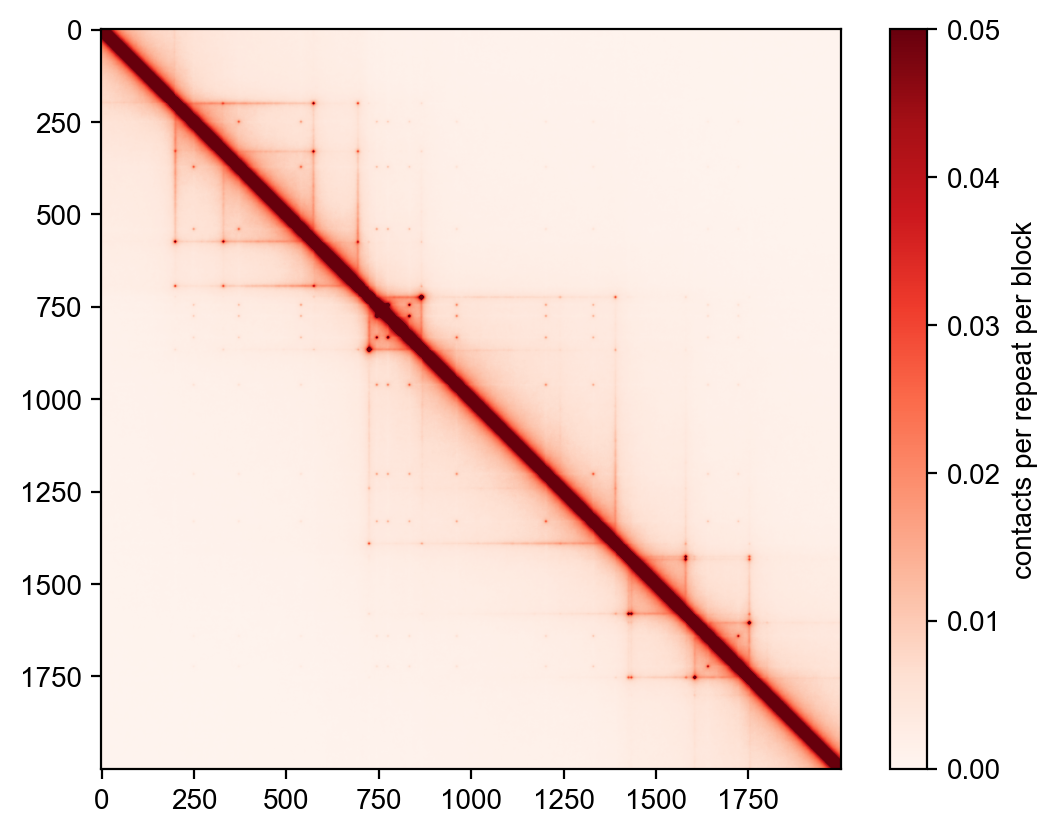

In [9]:
# rescale contact map so that each matrix element gives us the number of contacts per repeat per block
num_blocks = ((block_end-block_start)/block_step)
cm_rescaled = cm/num_blocks/35  # there are 35 repeats

# show rescaled contact map
plt.imshow(cm_rescaled, cmap='Reds', vmin=0, vmax=0.05);
plt.colorbar(label='contacts per repeat per block');

# Calculate the P(s) curve up to 2000 monomers

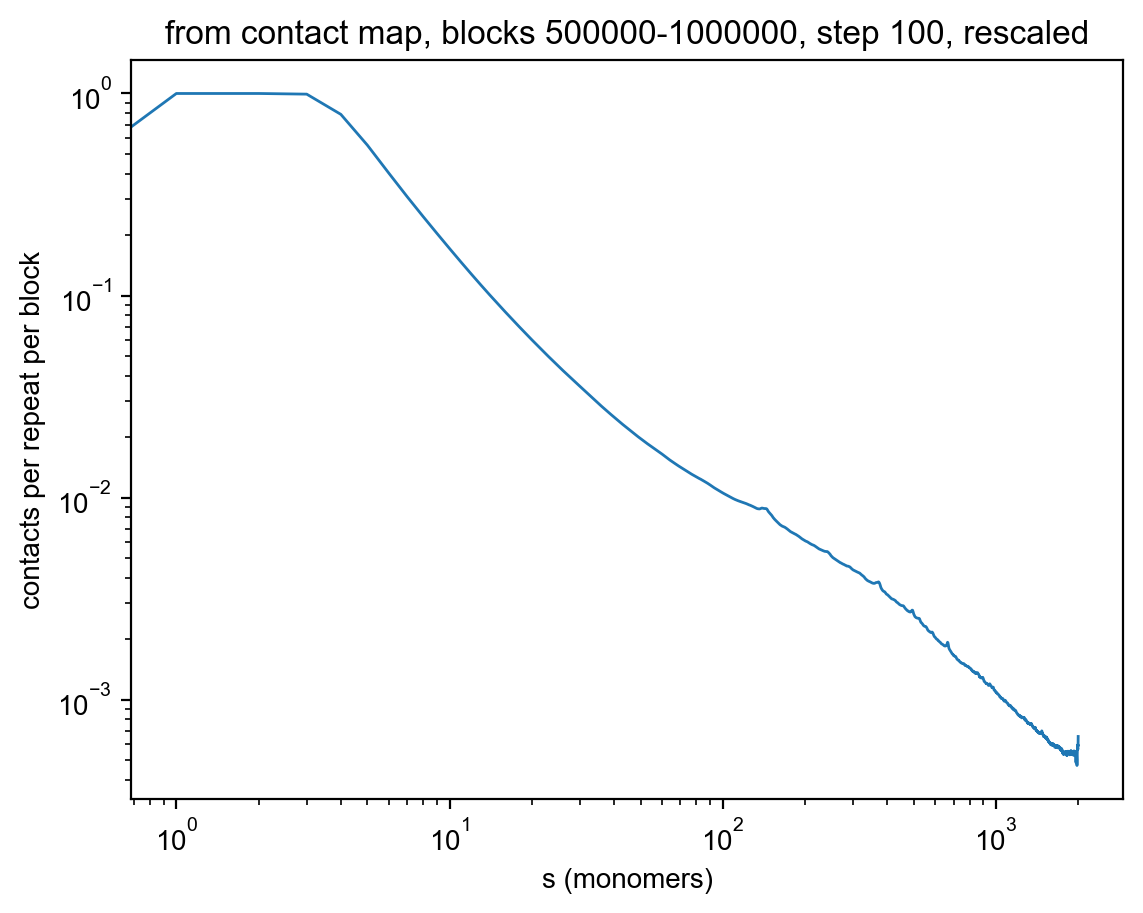

In [10]:
# from the rescaled contact map, get P(s) curve for s in 0-2000 monomer range

x1, y1 = get_Ps_curve_sim(cm_rescaled)
y1 = y1  # must divide by number of repeats
plt.plot(x1, y1, linewidth=1)
plt.xscale('log')
plt.yscale('log')
plt.title(f'from contact map, blocks {block_start}-{block_end}, step {block_step}, rescaled')
plt.xlabel('s (monomers)')
plt.ylabel('contacts per repeat per block');
plt.show()

In [14]:
# save result
np.savetxt('/mnt/md0/jjusuf/absloopquant/AbsLoopQuant_data/simulation_contact_map_P_s_curve_up_to_2000_monomers.txt', y1)

# Calculate P(s) curve for entire chromosome (up to 70000 monomers)

In [38]:
# get the P(s) curve the entire chromosome (s up to 70000 monomers)

s_arr_smoothed_dict = {}
P_s_arr_smoothed_dict = {}

cutoff = 3
s_arr = np.arange(10,70000,5)  # values of s to sample for P(s) curve

# parameters for smoothing P(s) curve
num_bins = 100
bin_edges_arr = np.concatenate((np.arange(10, 100, 5), np.round(np.logspace(2, 4.85, num_bins+1)).astype('int')))
bin_start_arr = bin_edges_arr[:-1]
bin_end_arr = bin_edges_arr[1:]

# block numbers at which to get P(s) curves
block_num_arr = np.linspace(500000,1000000,26).astype('int')  # step every 20000 blocks

for block_num in block_num_arr:
    block_data = load_URI(files[block_num])['pos']
    
    # calculate P(s) for each value of s
    P_s_arr = np.zeros(len(s_arr))
    for i, s in enumerate(s_arr):
        euclidean_distances = np.linalg.norm(block_data[:-s]-block_data[s:], ord=2, axis=1)
        P_s = np.mean(euclidean_distances < cutoff)
        P_s_arr[i] = P_s
        if s % 1000 == 0:  # show progress
            print(f'block_num={block_num}, s={s}, P_s={P_s}')
    
        s_arr_smoothed = np.zeros(len(bin_start_arr))
        P_s_arr_smoothed = np.zeros(len(bin_start_arr))
        
        for k in range(len(bin_start_arr)):
            bin_start = bin_start_arr[k]
            bin_end = bin_end_arr[k]
            s_bin = np.mean(s_arr[np.logical_and(s_arr>=bin_start, s_arr<bin_end)])
            P_s_bin = np.mean(P_s_arr[np.logical_and(s_arr>=bin_start, s_arr<bin_end)])
            s_arr_smoothed[k] = s_bin
            P_s_arr_smoothed[k] = P_s_bin
        
        s_arr_smoothed_dict[block_num] = s_arr_smoothed
        P_s_arr_smoothed_dict[block_num] = P_s_arr_smoothed

block_num=500000, s=1000, P_s=0.0009275362318840579
block_num=500000, s=2000, P_s=0.0004411764705882353
block_num=500000, s=3000, P_s=0.00044776119402985075
block_num=500000, s=4000, P_s=0.00028787878787878786
block_num=500000, s=5000, P_s=0.0003076923076923077
block_num=500000, s=6000, P_s=0.000171875
block_num=500000, s=7000, P_s=0.0005873015873015873
block_num=500000, s=8000, P_s=0.00011290322580645161
block_num=500000, s=9000, P_s=0.00014754098360655738
block_num=500000, s=10000, P_s=0.00013333333333333334
block_num=500000, s=11000, P_s=0.00010169491525423729
block_num=500000, s=12000, P_s=8.620689655172413e-05
block_num=500000, s=13000, P_s=1.7543859649122806e-05
block_num=500000, s=14000, P_s=0.00041071428571428574
block_num=500000, s=15000, P_s=0.00027272727272727274
block_num=500000, s=16000, P_s=0.00012962962962962963
block_num=500000, s=17000, P_s=0.0002641509433962264
block_num=500000, s=18000, P_s=0.0001346153846153846
block_num=500000, s=19000, P_s=1.9607843137254903e-05
b

In [39]:
# save the P(s) curve data

P_s_data = pd.DataFrame(columns=['block_num','s','P_s'])

for block_num in P_s_arr_smoothed_dict.keys():
    P_s_data = pd.concat((P_s_data, pd.DataFrame(data=(np.repeat(block_num, len(s_arr_smoothed)), s_arr_smoothed, P_s_arr_smoothed_dict[block_num]), index=['block_num','s','P_s']).T))

P_s_data = P_s_data.sort_values(['block_num', 's'])
P_s_data.to_csv('/mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data/P_s_curve_intermediate_calculations_from_3D_polysim_with_loopextr_with_EP_3kBT.csv')

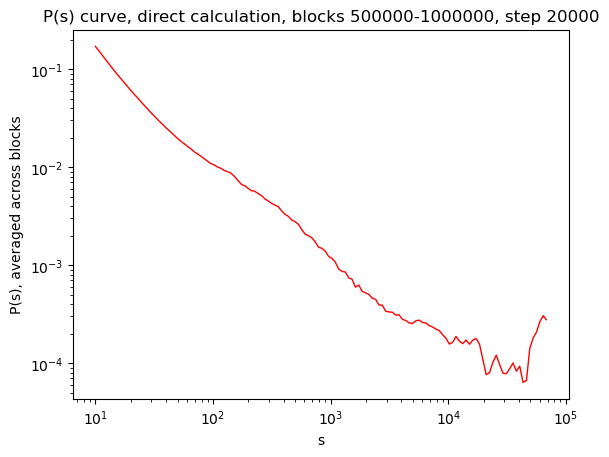

In [3]:
# open the P(s) curve data

P_s_data = pd.read_csv('/mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data/P_s_curve_intermediate_calculations_from_3D_polysim_with_loopextr_with_EP_3kBT.csv', index_col=0)

# average the P(s) data over blocks

s = P_s_data.loc[P_s_data['block_num']==700000.0,'s']  # just take any; it's the same for all blocks
s = np.sort(s)

block_nums = np.unique(P_s_data['block_num'])
block_nums = np.sort(block_nums)

num_blocks = len(block_nums)
num_data_points_per_block = np.sum(P_s_data['block_num']==700000)
P_s_data_to_use = np.zeros((num_data_points_per_block, num_blocks))
for j, block_num in enumerate(block_nums):
    P_s_data_to_use[:,j] = P_s_data.loc[P_s_data['block_num']==block_num,'P_s']

P_s_avg = P_s_data_to_use.mean(1)

# plot the P(s) curve data

plt.plot(s, P_s_avg, linewidth=1, color='red')
plt.xscale('log')
plt.yscale('log')
plt.title('P(s) curve, direct calculation, blocks 500000-1000000, step 20000')
plt.xlabel('s')
plt.ylabel('P(s), averaged across blocks');

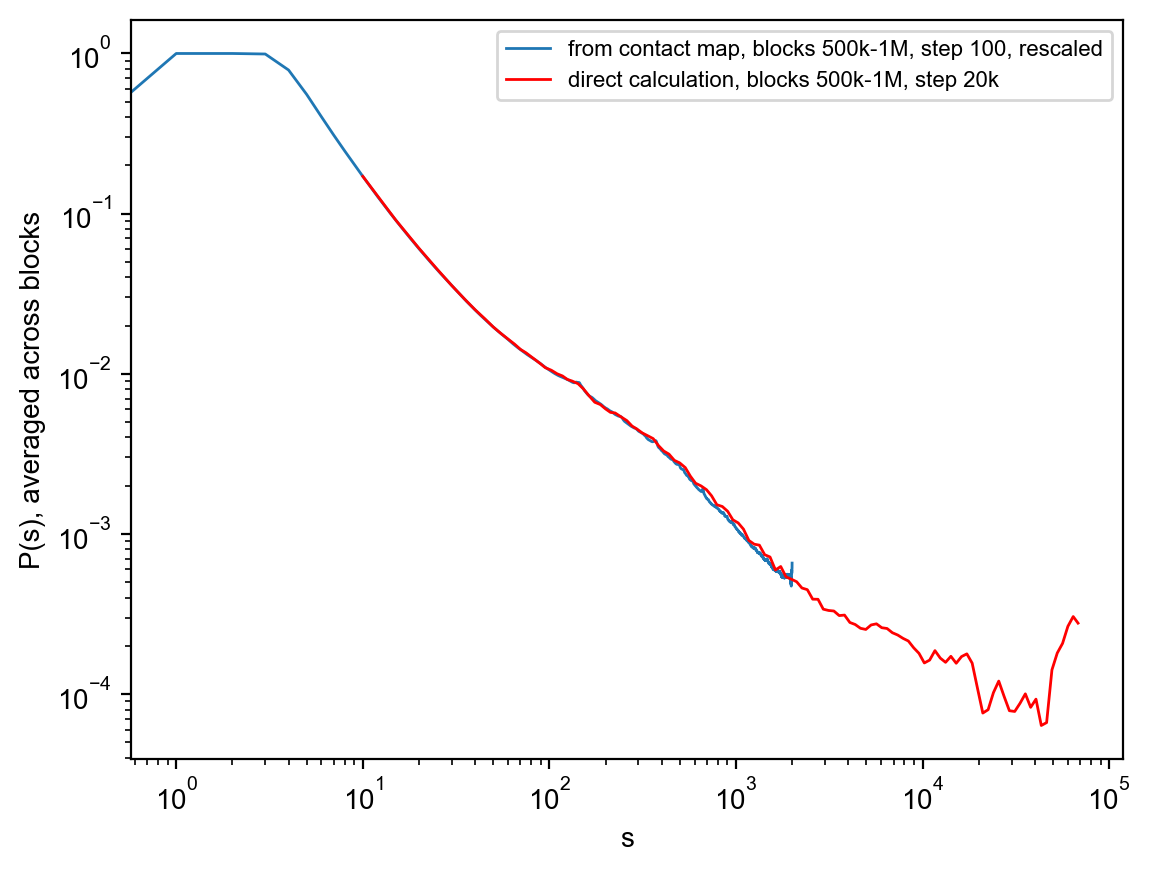

In [51]:
# double check that the P(s) curves coincide

plt.plot(x1, y1, linewidth=1)
plt.plot(s, P_s_avg, linewidth=1, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('s')
plt.ylabel('P(s), averaged across blocks')
plt.legend(['from contact map, blocks 500k-1M, step 100, rescaled','direct calculation, blocks 500k-1M, step 20k'], fontsize=8);

# Generate smoothed P(s) curve for entire chromosome

In [52]:
# fit functions to the P(s) curve

lower_bound_linear_portion = 2000
upper_bound_linear_portion = 30000

log10_s_to_fit = np.log10(s)[s<lower_bound_linear_portion]
log10_P_s_to_fit = np.log10(P_s_avg)[s<lower_bound_linear_portion]

best_fit_coeffs = np.polyfit(log10_s_to_fit, log10_P_s_to_fit, deg=6)

log10_s_to_fit_2 = np.log10(s)[np.logical_and(s>=lower_bound_linear_portion,s<upper_bound_linear_portion)]
log10_P_s_to_fit_2 = np.log10(P_s_avg)[np.logical_and(s>=lower_bound_linear_portion,s<upper_bound_linear_portion)]

best_fit_coeffs_2 = np.polyfit(log10_s_to_fit_2, log10_P_s_to_fit_2, deg=1)

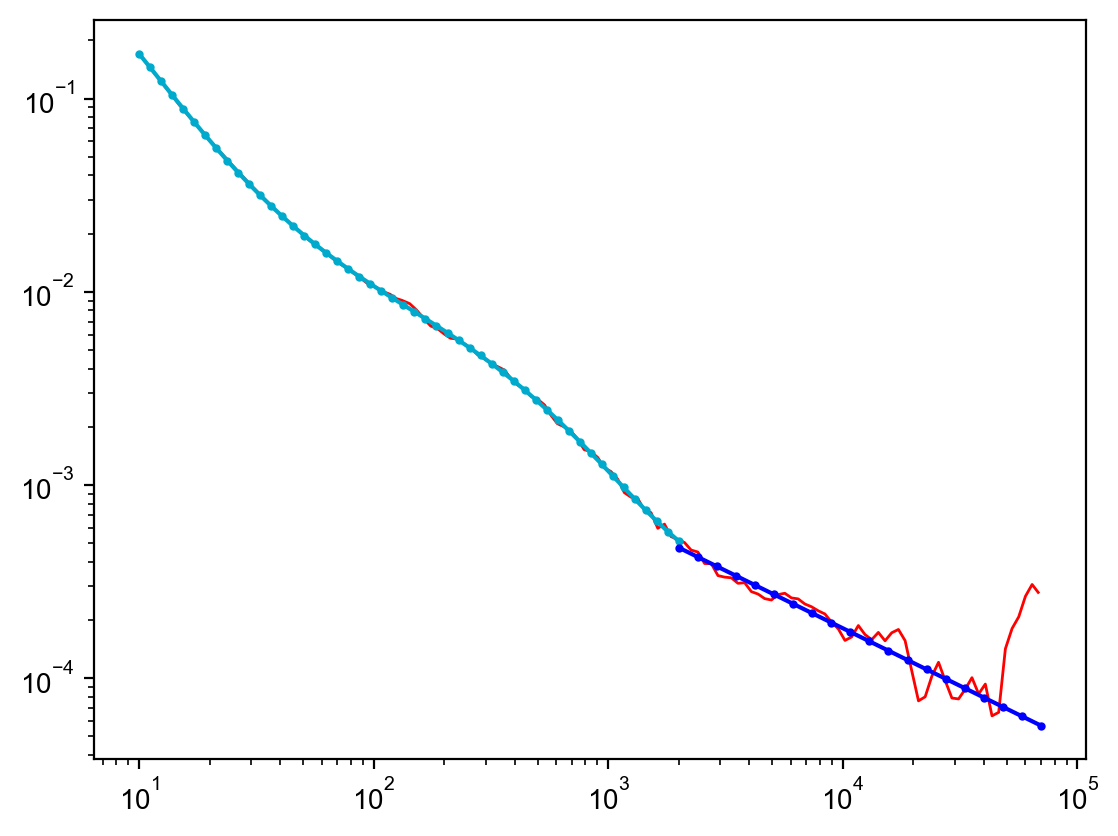

In [53]:
# plot the best-fit curves

log10_s_samp = np.linspace(1,np.log10(lower_bound_linear_portion),50)
s_samp = 10**log10_s_samp
P_best_fit = 10**np.polyval(best_fit_coeffs, log10_s_samp)

log10_s_samp_2 = np.linspace(np.log10(lower_bound_linear_portion),np.log10(70000),20)
s_samp_2 = 10**log10_s_samp_2
P_best_fit_2 = 10**np.polyval(best_fit_coeffs_2, log10_s_samp_2)

plt.plot(s, P_s_avg, linewidth=1, color='red')
plt.plot(s_samp, P_best_fit, marker='o', ms=2, color='#00aacc')
plt.plot(s_samp_2, P_best_fit_2, marker='o', ms=2, color='blue')
plt.xscale('log')
plt.yscale('log')

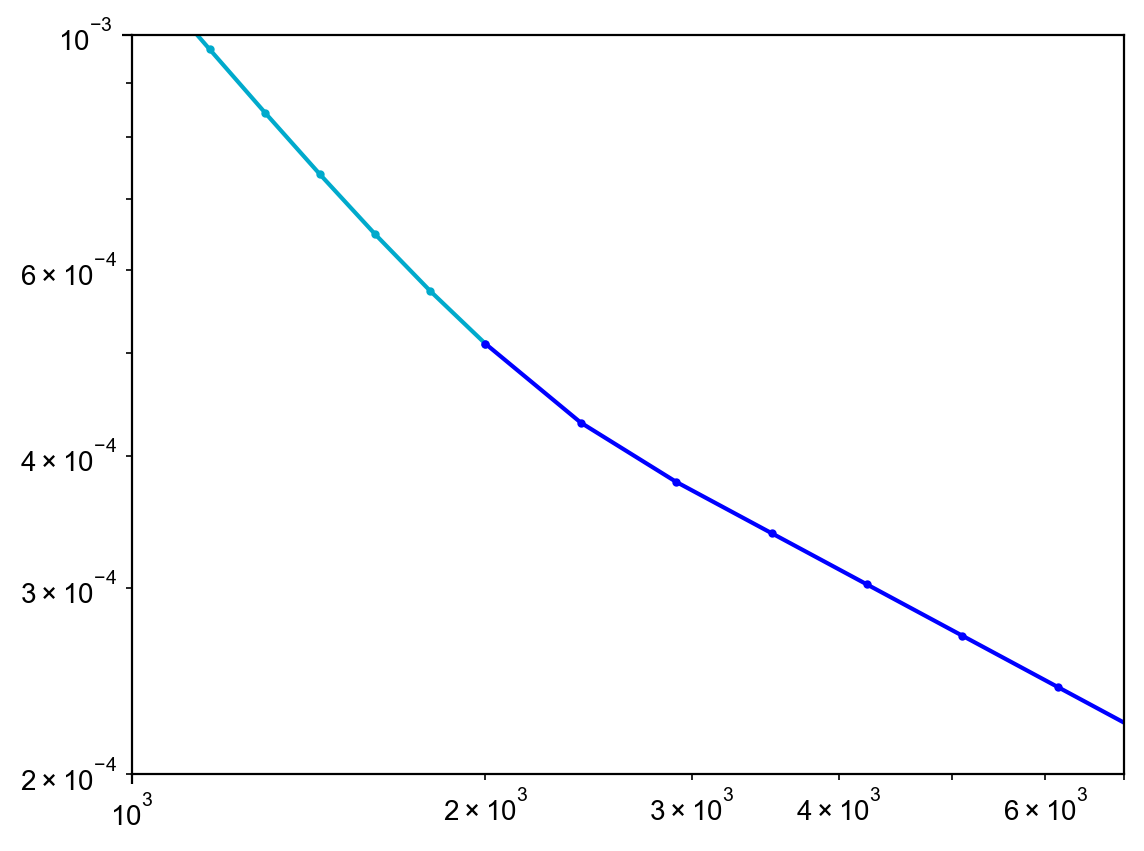

In [54]:
# manually perform smoothing to connect two curves

P_best_fit_2_fixed = P_best_fit_2.copy()
P_best_fit_2_fixed[0] = P_best_fit[-1]
P_best_fit_2_fixed[1] = 0.00043

plt.plot(s_samp, P_best_fit, marker='o', ms=2, color='#00aacc')
plt.plot(s_samp_2, P_best_fit_2_fixed, marker='o', ms=2, color='blue')
plt.xlim(1e3, 7e3)
plt.ylim(2e-4, 1e-3)
plt.xscale('log')
plt.yscale('log')

s_samp_final = np.concatenate((s_samp[:-1], s_samp_2))
P_s_best_final = np.concatenate((P_best_fit[:-1], P_best_fit_2_fixed))

best_fit_Ps_func = CubicSpline(s_samp_final, P_s_best_final)

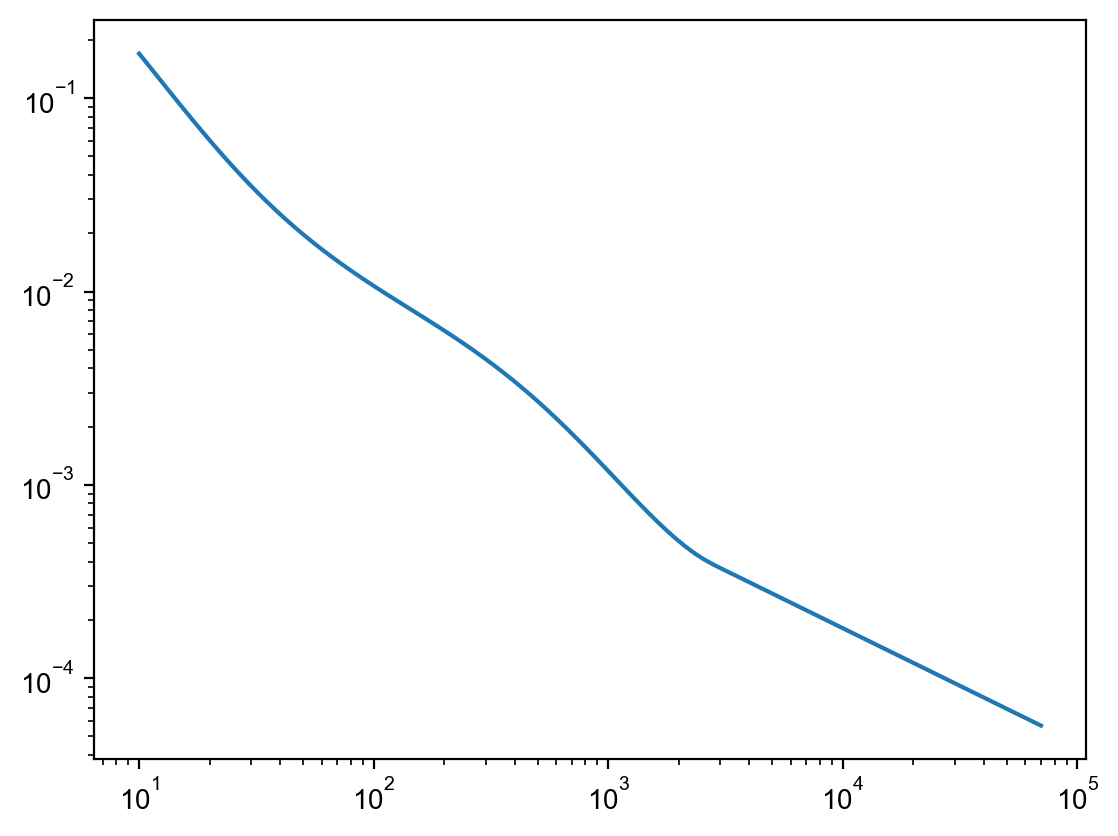

In [55]:
# show final P(s) curve

s_samp_plot_final = np.logspace(1, np.log10(70000), 100)
P_s_plot_final = best_fit_Ps_func(s_samp_plot_final)

plt.plot(s_samp_plot_final, P_s_plot_final)
plt.xscale('log')
plt.yscale('log')

In [56]:
# save final P(s) curve

P_s_data_final = np.zeros(70000)
for s in np.arange(0, 70000):
    P_s_data_final[s] = best_fit_Ps_func(s)
np.savetxt('/mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data/P_s_curve_data_3D_polysim_with_loopextr_with_EP_3kBT.txt', P_s_data_final)


# Generate cooler with simulated data

In [61]:
# start filling out the chromosome-wide bg2 table

def generate_bg2_file(i_start):
    with open(f'/mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data/contacts_3D_polysim_with_loopextr_with_EP_3kBT_{i_start}.bg2', 'w') as f:
        for i in range(i_start, i_start+1000):
            for j in range(70000):
                if j >= i:
                    if i//2000 == j//2000:
                        cm_value = int(cm_rescaled[i - i//2000*2000, j - j//2000*2000] * 100000)
                    else:
                        s = (j-i)*1000
                        if s < 10000:
                            cm_value = 0
                        else:
                            cm_value = int(best_fit_Ps_func(j-i) * 100000)
                    start1 = i*1000
                    end1 = (i+1)*1000
                    start2 = j*1000
                    end2 = (j+1)*1000
                    f.write(f'chrS\t{start1}\t{end1}\tchrS\t{start2}\t{end2}\t{cm_value}\n')

with Pool(70) as p:  # takes about 10 minutes -- make sure there are enough available CPU cores before running!
    p.map(generate_bg2_file, np.arange(0,70000,1000))

In [63]:
# command to combine everything -- takes about 20 minutes
# make sure there is enough disk space (a few hundred GB)!

sp.run('cd /mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data; cat '+' '.join([f'contacts_3D_polysim_with_loopextr_with_EP_3kBT_{i_start}.bg2' for i_start in np.arange(0,70000,1000)]) + ' > contacts_3D_polysim_with_loopextr_with_EP_3kBT_all.bg2', shell=True)


CompletedProcess(args='cd /mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data; cat contacts_3D_polysim_with_loopextr_with_EP_3kBT_0.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_1000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_2000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_3000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_4000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_5000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_6000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_7000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_8000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_9000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_10000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_11000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_12000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_13000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_14000.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_15000.bg2 contacts_3D

In [64]:
# create bed file of bins

with open(f'/mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data/chrS_bins.bed', 'w') as f:
    for i in range(0, 70000):
        f.write(f'chrS\t{i*1000}\t{(i+1)*1000}\n')

In [ ]:
# create cooler

sp.run('cd /mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data; cooler load -f bg2 chrS_bins.bed contacts_3D_polysim_with_loopextr_with_EP_3kBT_all.bg2 contacts_3D_polysim_with_loopextr_with_EP_3kBT_all.cool', shell=True)


In [ ]:
# balance cooler

sp.run('cd /mnt/coldstorage/jjusuf/simabsloopquant_data/analysis_data; cooler balance --ignore-dist 20000 -p 50 contacts_3D_polysim_with_loopextr_with_EP_3kBT_all.cool', shell=True)
